In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from qiskit import *
from qiskit.compiler import assemble
from qiskit.pulse.commands.sample_pulse import SamplePulse
from scipy.optimize import curve_fit 
import random
import math
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib
from qiskit.providers.aer import PulseSimulator
from qiskit.providers.aer.pulse import PulseSystemModel

In [31]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_armonk')
props, backend_config, defaults = (backend.properties(), backend.configuration(), backend.defaults())

ibmqfactory.load_account:WARNING:2020-06-30 14:23:25,018: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import numpy as np

backend_defaults = backend.defaults()
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

Sampling time: 0.2222222222222222 ns
Qubit 0 has an estimated frequency of 4.974455162624343 GHz.


In [4]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
from qiskit.pulse import pulse_lib  # This Pulse module helps us build sampled pulses for common pulse shapes

In [24]:
Xp = lambda i: pulse.commands.SamplePulse([p for p in defaults.pulse_library
                 if p.name=='Xp_d'+str(i)][0].samples, 'Xp'+str(i))

In [5]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit)

In [20]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
#     y_fit = function(x_values, *fitparams)
    
    return fitparams

# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [7]:
# A value to use if previous cells of notebook were not run
pi_amp = 0.347467
drive_duration = 2048
drive_sigma = 256

# Infer the value of the drive strength from the pi pulse amplitude:
dt = getattr(backend.configuration(), 'dt')
from qiskit.pulse import pulse_lib
sample_array = pulse_lib.gaussian(duration=drive_duration, amp=1, sigma=drive_sigma).samples
A = pi_amp*sum(sample_array*dt) # area under curve
omegad0 = np.real(np.pi/(A * 2)) # inferred drive strength

# set drive strength omegad0 in backend object
getattr(backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
# set the qubit frequency from the estimate in the defaults
freq_est = getattr(backend.defaults(), 'qubit_freq_est')[0]
getattr(backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

armonk_model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator()

In [8]:
shots = 1024 # determines clarity of results

period = 1000 # Rabi oscillation period
cycles = [5] # number of rabi cycles to perform for each oscillation
datapoints_per_period = 50 # density of datapoints in a cycle capture
cycles_to_plot = 3 # cycles to capture oscillation with, integer

scale_factor = 1e-14
predict_const = 396.82938853064877 #54.07447683508908
predict_power =  -1.0324290902994375 #-0.9924372112785861

sig_predict_const =  87.54344062139323 #11.48089749887833 
sig_predict_power =  -0.986135023870862 #-0.9672752940591574

In [32]:
# begin with no pulses in the experiment
experiments = []

data_times = []
drive_amp = np.power(period/predict_const,1/predict_power)

# make array of constant pulses that we can use to make all drive lengths
constant_pulse_lengths = [2**i for i in range(17)] # largest i that you can fit in 250,000 pulse samples
constant_pulses = []
for i in constant_pulse_lengths: 
    constant_pulses.append(pulse_lib.Constant(duration=i, amp=drive_amp))

s = lambda amp: sig_predict_const * np.power(amp, sig_predict_power)
drive_sigma = int(s(drive_amp))

for cycle in cycles:
    drive_duration = period*cycle    
    center_meas = get_closest_multiple_of_16(cycle*period)
    datapoints_per_period = 6
    data_separation = period // datapoints_per_period

    drive_times = range(center_meas - get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        center_meas + get_closest_multiple_of_16(cycles_to_plot*data_separation*datapoints_per_period/2),
                        16)
    for i in range(len(drive_times)):  
        normal_gauss_square = pulse_lib.GaussianSquare(duration=drive_times[i], amp=drive_amp,
                            sigma=drive_sigma, width=drive_times[i]-(6*drive_sigma)).get_sample_pulse()
        front_cap = pulse.commands.SamplePulse(normal_gauss_square.samples[:3*drive_sigma],'front_cap')
        end_cap = pulse.commands.SamplePulse(front_cap.samples[::-1],'end_cap')
        consts = []
        this_schedule = pulse.Schedule(name=f"Rabi duration = {i}")

        # add front cap
        consts.append(front_cap.samples)

        if (drive_times[i] > sum(constant_pulse_lengths)):
            extra_time = drive_times[i]
            while (extra_time > sum(constant_pulse_lengths)):
                consts.append(constant_pulses[-1].get_sample_pulse().samples)
#                 this_schedule += Play(constant_pulses[-1], drive_chan)
                extra_time -= constant_pulse_lengths[-1]
            bin_time = '{0:b}'.format(extra_time)
            for i in range(len(bin_time)):
                if (bin_time[i] == '1'):
                    consts.append(constant_pulses[i].get_sample_pulse().samples)
#                     this_schedule += Play(constant_pulses[i], drive_chan)
        else:
            bin_time = '{0:b}'.format(drive_times[i])[::-1]
            for i in range(len(bin_time)):
                if (bin_time[i] == '1'):
                    consts.append(constant_pulses[i].get_sample_pulse().samples)

        # add end cap
        consts.append(end_cap.samples)
        
        long_pulse = np.concatenate(consts, axis=0)
        this_schedule += Play(SamplePulse(long_pulse, name="long pulse"), drive_chan)

        this_schedule += measure << this_schedule.duration
        experiments.append(this_schedule)

    data_times.append(drive_times)

In [35]:
len(experiments)

188

In [33]:
benewop_jobs = []
num_shots_per_point = 1024

schedule = pulse.Schedule(name='|0> state')
schedule += measure << schedule.duration
experiments.append(schedule) # add zero state to experiments
schedule = pulse.Schedule(name='|1> state')
schedule += Play(SamplePulse(Xp(qubit).samples), drive_chan)
schedule += measure << schedule.duration
experiments.append(schedule) # add 1 state to experiments

program = assemble(experiments,
                   backend=backend,
                   meas_level=1,
                   meas_return='avg',
                   shots=num_shots_per_point)
job = backend_sim.run(program, armonk_model).result()
benewop_jobs.append(job)

In [34]:
all_results = []
for i in range(len(experiments)):
    all_results.append(np.angle(results.get_memory(i)[qubit] * scale_factor, deg=True))

IndexError: list index out of range

In [21]:
qb_rabi_data = []
all_params = []
all_fits = []
num_experiments = sum([len(x) for x in data_times])

state0 = all_results[len(all_results)-2]
state1 = all_results[len(all_results)-1]

past_exp = 0
for i in range(len(cycles)):
    single_period_data = []
    for j in range(len(data_times[i])):
        # Get the results for `qubit` from the ith experiment
        single_period_data.append(all_results[past_exp+j])

    qb_rabi_data.append(single_period_data)
    past_exp += len(data_times[i])
    
    fun = lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B)
    p = fit_function(list(data_times[i]), qb_rabi_data[i], fun, 
                     [np.max(qb_rabi_data[i]) - np.min(qb_rabi_data[i]), 0, period, 0])
    all_params.append(p)
    
    y_fit = [fun(x, p[0], p[1], p[2], p[3]) for x in list(data_times[i])]
    all_fits.append(y_fit)

C:\Users\nfberthusen\AppData\Roaming\Python\Python36\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Period: 1000.0 dt


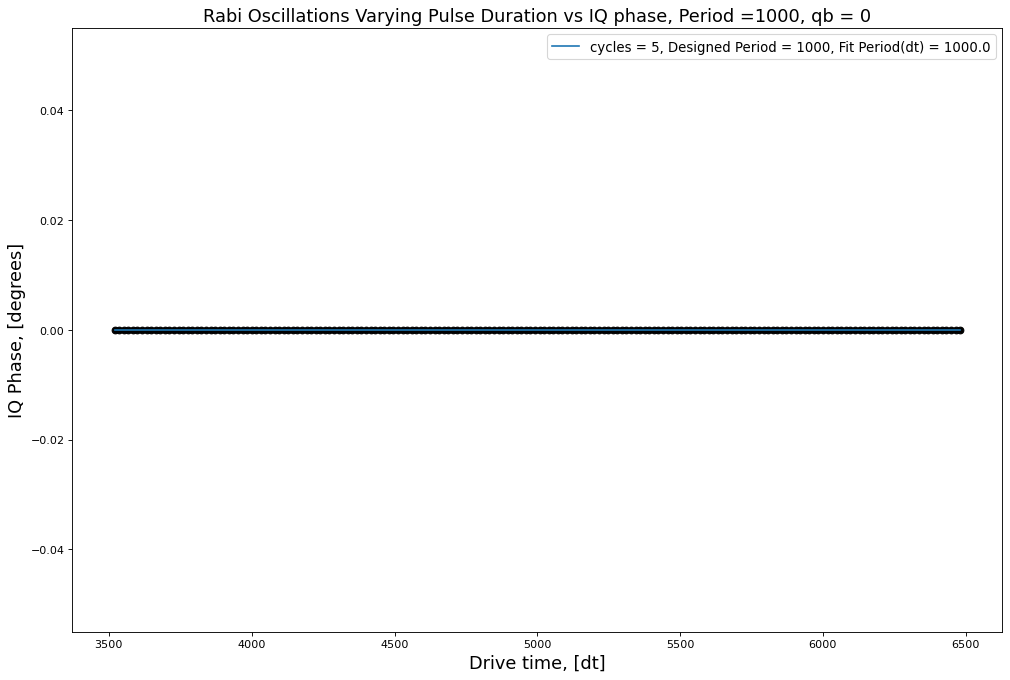

In [23]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

# end_plot_time = (period*cycles[-1])+(len(data_times[-1])*16)
# plt.plot([0, end_plot_time],2*[state0],label="|0> state")
# plt.plot([0, end_plot_time],2*[state1],label="|1> state")

for i in range(len(cycles)):
    plt.scatter(data_times[i], qb_rabi_data[i], color='black') # plot real part of Rabi values
    plt.plot(data_times[i], all_fits[i],
    label="cycles = " + str(cycles[i]) + ", Designed Period = " + str(period) + ", Fit Period(dt) = " + str(np.around(all_params[i][2],decimals=4)))
print(f'Period: {p[2]} dt')
plt.legend(loc='upper right', fontsize=12)
plt.xlabel('Drive time, [dt]', fontsize=16)
plt.ylabel('IQ Phase, [degrees]', fontsize=16)
plt.title("Rabi Oscillations Varying Pulse Duration vs IQ phase, Period =" + str(period) + ", qb = " + str(qubit), fontsize=16)
plt.show()